# Preliminary Operations
The same imports and auxiliary code is defined below:

In [ ]:
from google.colab import drive
import os
import tensorflow as tf
from tensorflow import keras
from keras import layers
import numpy as np
import random as rn
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from tensorflow.keras.applications.vgg16 import preprocess_input

#drive.mount('/content/drive')

In [ ]:
#ROOT_DIR = "/content/drive/Shareddrives/Giaquinta_Pasqualetti/"
ROOT_DIR = "/content/sample_data/content/drive/Shareddrives/Giaquinta_Pasqualetti/"

IMAGES_DIR = os.path.join(ROOT_DIR, "Data")
TRAIN_DIR = os.path.join(IMAGES_DIR, "Train")
TEST_DIR = os.path.join(IMAGES_DIR, "Test")

IMAGE_DIM = 64
RAN_SEED = 10024062

VALIDATION_SPLIT = 0.1
TRAIN_SPLIT = 0.2

NOTE: Interactions with Google Drive are commented out. For our own testing, we used files stored locally in the session to **significantly** speed up the computation. To run this notebook using files stored in Google Drive, uncomment the lines that are currently commented and comment out the lines that are using local files.

In [ ]:
#! rm -r /content/drive/Shareddrives/Giaquinta_Pasqualetti/Data
#! unzip -q /content/drive/Shareddrives/Giaquinta_Pasqualetti/Data.zip -d /

! rm -r /content/sample_data/*
! unzip -q /content/Data.zip -d /content/sample_data/

In [ ]:
# Set all the seeds, to create datasets and Tensors from the same starting point
def set_seed():
    os.environ["PYTHONHASHSEED"]="0"
    np.random.seed(RAN_SEED)
    rn.seed(RAN_SEED)
    tf.random.set_seed(RAN_SEED)

# Returns Train, Val and Test sets
# BATCH_SIZE is user-given input, VALIDATION_SPLIT is 0.1
def load_datasets(BATCH_SIZE):
    set_seed()

    train = tf.keras.preprocessing.image_dataset_from_directory(
        TRAIN_DIR, labels='inferred', label_mode='categorical', class_names=None,
        color_mode='rgb', batch_size=BATCH_SIZE, shuffle=True, seed=RAN_SEED,
        validation_split=VALIDATION_SPLIT, subset='training', follow_links=False,
        image_size=(64,64)
    )

    val = tf.keras.preprocessing.image_dataset_from_directory(
        TRAIN_DIR, labels='inferred', label_mode='categorical', class_names=None,
        color_mode='rgb', batch_size=BATCH_SIZE, shuffle=True, seed=RAN_SEED,
        validation_split=VALIDATION_SPLIT, subset='validation', follow_links=False,
        image_size=(64,64)
    )

    test = tf.keras.preprocessing.image_dataset_from_directory(
        TEST_DIR, labels='inferred', label_mode='categorical',
        class_names=None, color_mode='rgb', batch_size=BATCH_SIZE, shuffle=True,
        seed=RAN_SEED, follow_links=False, image_size=(64,64)
    )

    return train, val, test

# Returns some details about trained model
def train_performance(history):

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'bo', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

# Test
def show_res(model, test):
  data, labels = [], []

  for data_batch, labels_batch in test:
    data.append(data_batch)
    labels.append(labels_batch)

  data = tf.concat(data, axis=0)
  labels = tf.concat(labels, axis=0)

  y_score = model.predict(data)

  y_pred = np.rint(y_score)

  y_true = np.asarray(labels)

  y_pred = np.argmax(y_score, axis=1)
  y_test = np.argmax(y_true, axis=1)

  print("Classification report: ")
  print(metrics.classification_report(y_test,y_pred ,digits = 4))


  cm = metrics.confusion_matrix(y_test, y_pred)
  disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot()
  plt.show()


# Function to plot multi-class ROC curves
def plot_multiclass_roc(model, test_data):
    test_images, test_labels = [], []

    for data_batch, labels_batch in test_data:
        test_images.append(data_batch)
        test_labels.append(labels_batch)

    test_images = np.concatenate(test_images, axis=0)
    test_labels = np.concatenate(test_labels, axis=0)

    # Preprocess images
    test_images = preprocess_input(test_images)

    # Get predicted scores for all classes
    y_scores = model.predict(test_images)

    # Binarize labels
    y_true = label_binarize(np.argmax(test_labels, axis=1), classes=range(10))

    # Compute ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(10):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_scores[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves in a single plot
    plt.figure(figsize=(10, 8))
    for i in range(10):
        plt.plot(fpr[i], tpr[i], label='Class %d (AUC = %0.2f)' % (i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-Class ROC Curves')
    plt.legend(loc="lower right")
    plt.show()


def model_summary(model):
  from keras.utils.vis_utils import plot_model

  model.summary()
  plot_model(model, show_shapes=True, show_layer_names=True)


# VGG16 with Feature Extraction
Importing the **VGG16** Keras model. VGG16 is a deep neural network architecture known for its simplicity and effectiveness in image classification. It consists of 16 layers, mostly using 3x3 convolutional filters and 2x2 max-pooling layers. VGG16 captures features at different scales, making it useful for tasks like recognizing objects in images. Its pre-trained weights enable quick adaptation to new tasks, making it a popular choice for transfer learning.

Using VGG16 for satellite image land use classification is beneficial due to its hierarchical feature extraction, pre-trained weights, transfer learning potential, ability to handle large input sizes, and suitability for diverse landscapes. It offers good generalization and customization while aiding visual interpretation of features.

In [ ]:
from tensorflow.keras.applications import VGG16

conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(64, 64, 3))

conv_base.summary()

58889256/58889256 [==============================] - 2s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                              

Layer freezing is needed to fix the weights of certain neural network layers during training, commonly for transfer learning, to retain learned features and prevent them from being changed.

In [ ]:
print('Number of trainable weights: ', sum(np.prod(x.shape) for x in conv_base.trainable_weights))
conv_base.trainable = False
print('Number of trainable weights after freezing the convolutional base:', sum(np.prod(x.shape) for x in conv_base.trainable_weights))

Number of trainable weights:  14714688
Number of trainable weights after freezing the convolutional base: 0


## **First try:** 256 neurons with adam optimizer
The conv_base initiates the feature extraction phase. As our parameters we decided to set the number of neurons in the dense layer to 256 and the number of neurons in the dense layer to 256, without any L2 regularization, dropout or data augmentation, which will be later added if necessary. The chosen optimizer is Adam.

In [ ]:
inputs = keras.Input(shape=(64, 64, 3))
x = inputs
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
outputs = layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 tf.__operators__.getitem (S  (None, 64, 64, 3)        0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 64, 64, 3)        0         
                                                                 
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                             

In [ ]:
callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=5,
    ),
    keras.callbacks.ModelCheckpoint(
        #'/content/drive/Shareddrives/Giaquinta_Pasqualetti/Models/vgg16_simple.h5',
        '/content/vgg16_simple.h5',
        monitor='val_loss',
        mode='min',
        save_best_only=True,
    )
]

Found 22000 files belonging to 10 classes.
Using 19800 files for training.
Found 22000 files belonging to 10 classes.
Using 2200 files for validation.
Found 5400 files belonging to 10 classes.
Epoch 1/15
310/310 [==============================] - 17s 24ms/step - loss: 2.7493 - accuracy: 0.8478 - val_loss: 2.0443 - val_accuracy: 0.8795
Epoch 2/15
310/310 [==============================] - 7s 22ms/step - loss: 1.0906 - accuracy: 0.9112 - val_loss: 1.5323 - val_accuracy: 0.8895
Epoch 3/15
310/310 [==============================] - 6s 18ms/step - loss: 0.6413 - accuracy: 0.9301 - val_loss: 1.4087 - val_accuracy: 0.8805
Epoch 4/15
310/310 [==============================] - 6s 18ms/step - loss: 0.4319 - accuracy: 0.9382 - val_loss: 1.4078 - val_accuracy: 0.8782
Epoch 5/15
310/310 [==============================] - 7s 21ms/step - loss: 0.3327 - accuracy: 0.9454 - val_loss: 1.2426 - val_accuracy: 0.8873
Epoch 6/15
310/310 [==============================] - 7s 21ms/step - loss: 0.2458 - accurac

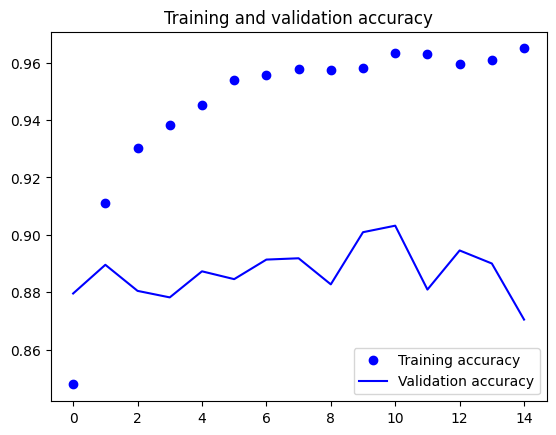

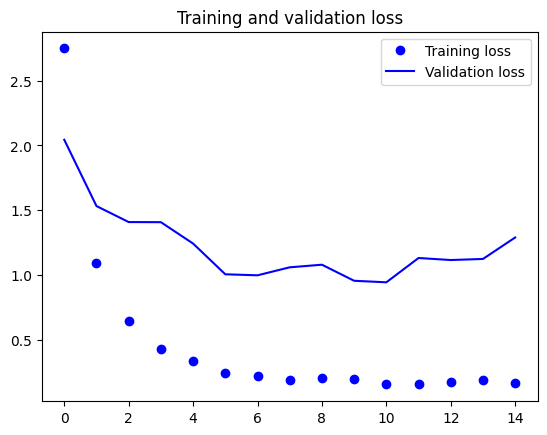

169/169 [==============================] - 1s 5ms/step
Classification report: 
              precision    recall  f1-score   support

           0     0.9331    0.8600    0.8951       600
           1     0.9922    0.8450    0.9127       600
           2     0.8412    0.8917    0.8657       600
           3     0.7932    0.7980    0.7956       500
           4     0.8800    0.9680    0.9219       500
           5     0.7609    0.9150    0.8309       400
           6     0.8053    0.8520    0.8280       500
           7     0.9731    0.9033    0.9369       600
           8     0.8160    0.8340    0.8249       500
           9     0.9807    0.9300    0.9547       600

    accuracy                         0.8796      5400
   macro avg     0.8776    0.8797    0.8766      5400
weighted avg     0.8859    0.8796    0.8808      5400



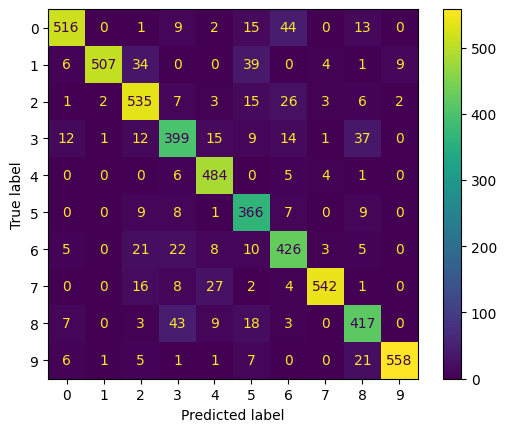

169/169 [==============================] - 1s 5ms/step


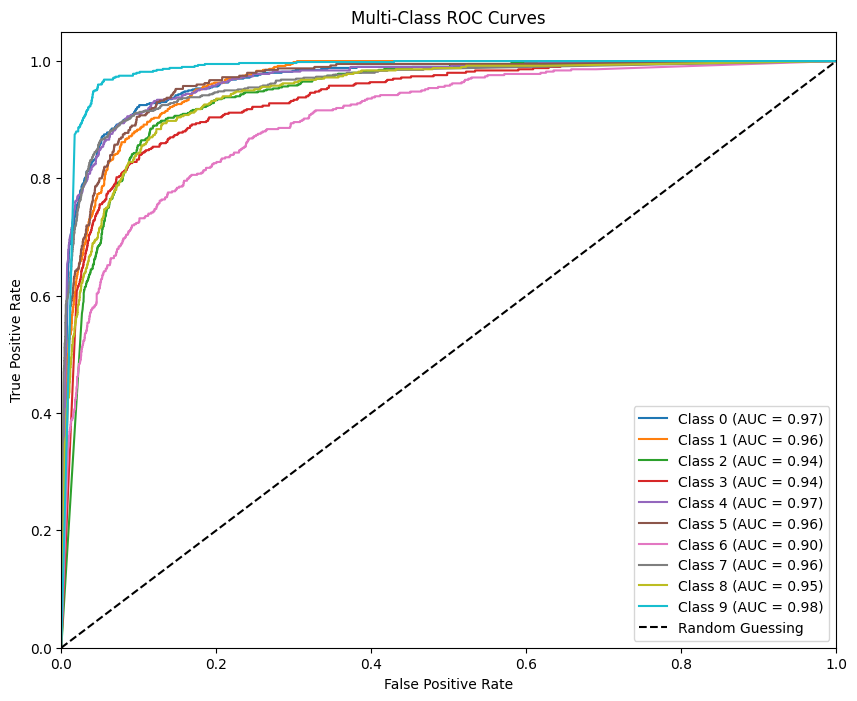

In [ ]:
train, val, test = load_datasets(BATCH_SIZE = 64)
res = model.fit(train, epochs=15, validation_data=val, callbacks = callbacks_list)
train_performance(res)
show_res(model, test)
plot_multiclass_roc(model, test)

## **Second try:** addressing the overfitting
The results indicate that the validation accuracy is lower than the training accuracy, and the validation loss is higher than the training loss by a significant margin. It is possible that the accuracy might not improve significantly or not improve at all. However, let's attempt to reduce overfitting so that the classification model is sufficiently generalized to consistently deliver this level of performance. To begin with, we will implement dropout and add a data augmentation layer.

Let's repeat the experiment:

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 tf.__operators__.getitem_1   (None, 64, 64, 3)        0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 64, 64, 3)        0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               5245

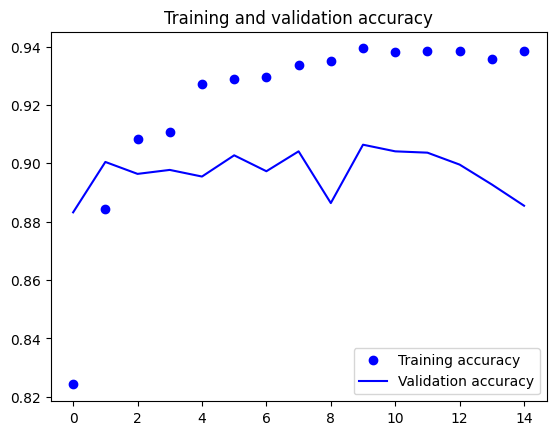

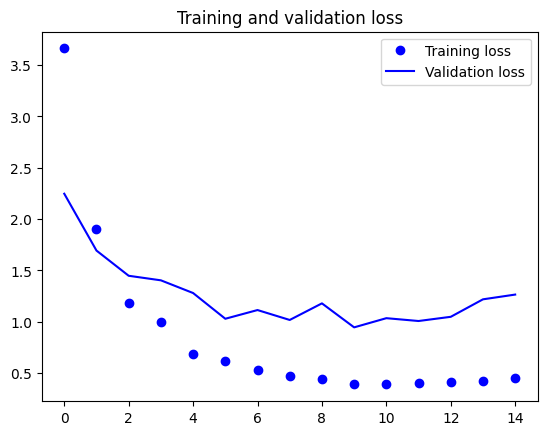

169/169 [==============================] - 1s 5ms/step
Classification report: 
              precision    recall  f1-score   support

           0     0.9268    0.8650    0.8948       600
           1     0.9924    0.8667    0.9253       600
           2     0.8851    0.8600    0.8724       600
           3     0.7905    0.8300    0.8098       500
           4     0.9280    0.9540    0.9408       500
           5     0.7581    0.9400    0.8393       400
           6     0.7993    0.9000    0.8467       500
           7     0.9874    0.9167    0.9507       600
           8     0.8858    0.8220    0.8527       500
           9     0.9528    0.9750    0.9638       600

    accuracy                         0.8924      5400
   macro avg     0.8906    0.8929    0.8896      5400
weighted avg     0.8985    0.8924    0.8935      5400



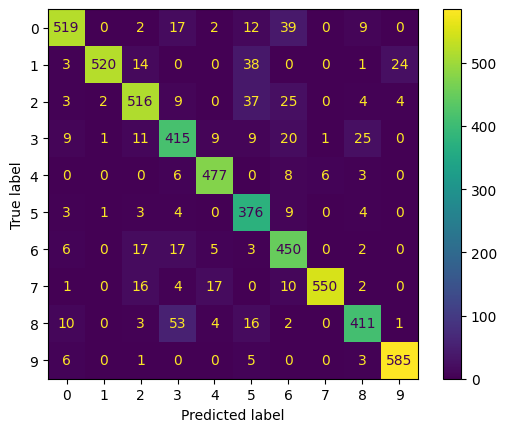

169/169 [==============================] - 1s 5ms/step


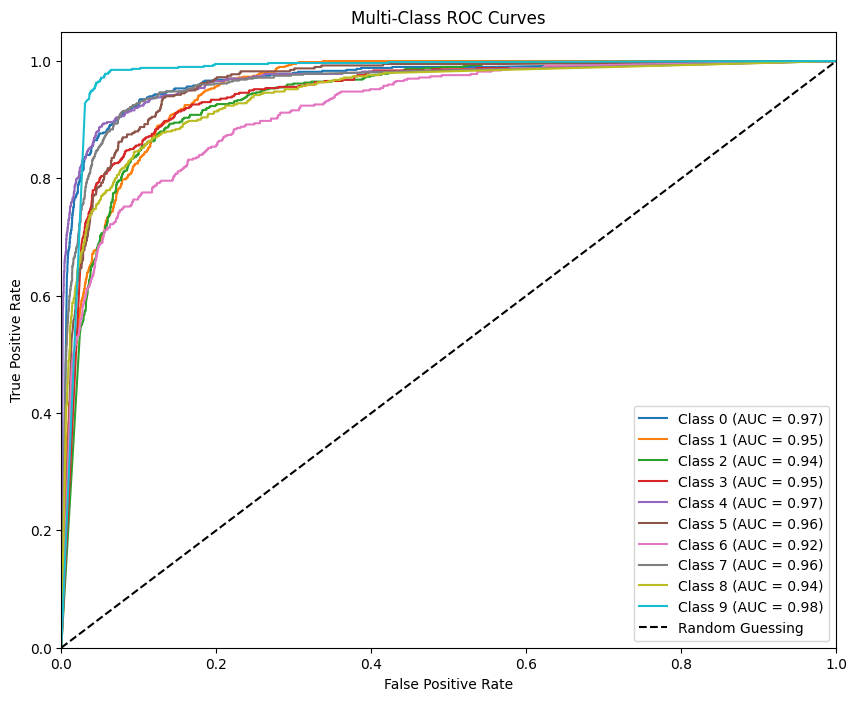

In [ ]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
])

inputs = keras.Input(shape=(64, 64, 3))
x = data_augmentation(inputs)
x = inputs
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])
model.summary()

callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=5,
    ),
    keras.callbacks.ModelCheckpoint(
        #'/content/drive/Shareddrives/Giaquinta_Pasqualetti/Models/vgg16_dropout_augment.h5',
        '/content/vgg16_dropout_augment.h5',
        monitor='val_loss',
        mode='min',
        save_best_only=True,
    )
]

train, val, test = load_datasets(BATCH_SIZE = 64)
res = model.fit(train, epochs=15, validation_data=val, callbacks = callbacks_list)
train_performance(res)
show_res(model, test)
plot_multiclass_roc(model, test)

## **Third try:** Data regularization
Presently, an instance of overfitting can still be observed. The magnitude of the problem has decreased thanks to the dropout and data augmentation layer. Let's attempt to address this once and for all by also incorporating L2 regularization into the dense layer.

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 tf.__operators__.getitem_2   (None, 64, 64, 3)        0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_2 (TFOpLambd  (None, 64, 64, 3)        0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 256)               5245

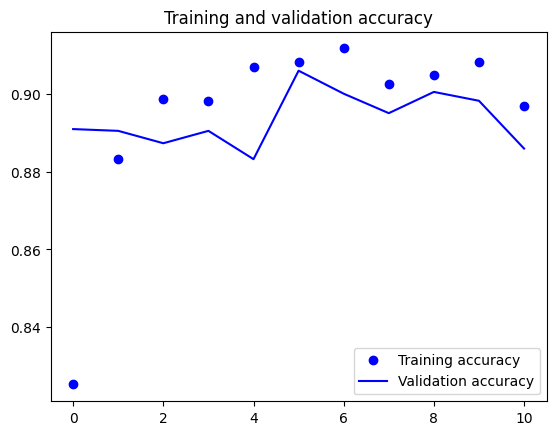

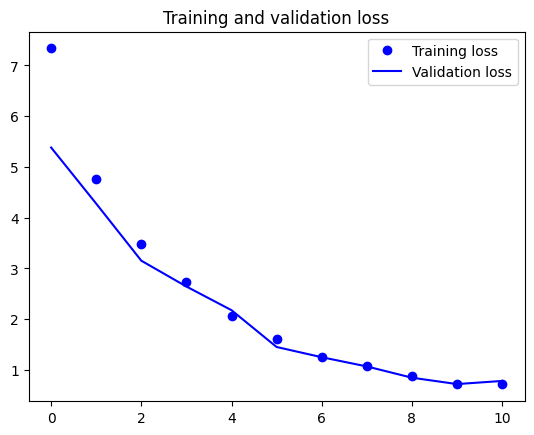

169/169 [==============================] - 1s 5ms/step
Classification report: 
              precision    recall  f1-score   support

           0     0.9232    0.9217    0.9224       600
           1     0.9590    0.9367    0.9477       600
           2     0.8835    0.8850    0.8843       600
           3     0.8632    0.6560    0.7455       500
           4     0.9411    0.9260    0.9335       500
           5     0.7403    0.9550    0.8341       400
           6     0.9246    0.7360    0.8196       500
           7     0.9531    0.9483    0.9507       600
           8     0.7227    0.9120    0.8064       500
           9     0.9583    0.9583    0.9583       600

    accuracy                         0.8865      5400
   macro avg     0.8869    0.8835    0.8802      5400
weighted avg     0.8941    0.8865    0.8860      5400



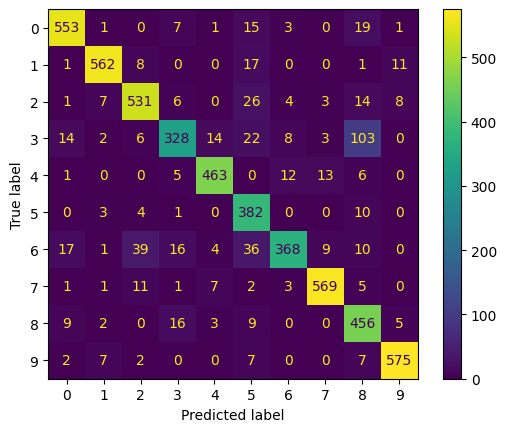

169/169 [==============================] - 1s 6ms/step


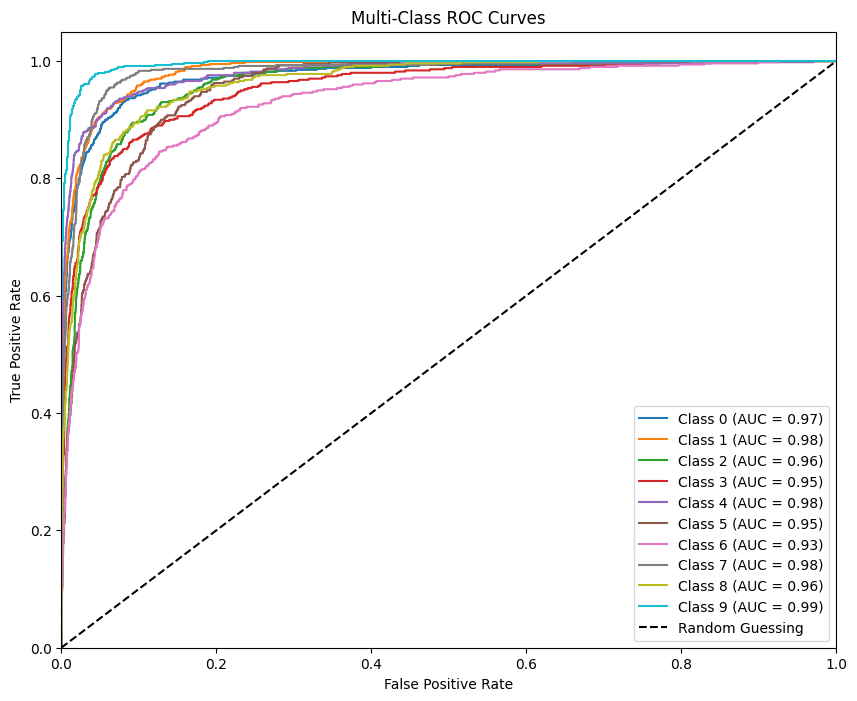

In [ ]:
from keras.regularizers import l2

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
])

inputs = keras.Input(shape=(64, 64, 3))
x = data_augmentation(inputs)
x = inputs
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256, kernel_regularizer=l2(0.01))(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])
model.summary()

callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=5,
    ),
    keras.callbacks.ModelCheckpoint(
        #'/content/drive/Shareddrives/Giaquinta_Pasqualetti/Models/vgg16_final.h5',
        '/content/vgg16_final.h5',
        monitor='val_loss',
        mode='min',
        save_best_only=True,
    )
]

train, val, test = load_datasets(BATCH_SIZE = 64)
res = model.fit(train, epochs=15, validation_data=val, callbacks = callbacks_list)
train_performance(res)
show_res(model, test)
plot_multiclass_roc(model, test)

# Fine Tuning
While this might not be the best idea (fine-tuning assumes that a model has been trained on similar data and with similar classes), we decided to try this approach anyway because we lack precise knowledge of the VGG16 model and because of the limited size of our dataset; we cannot definitively state that this will lead to worse results.

The model is composed of 19 layers as we can see below:

In [ ]:
#model = tf.keras.models.load_model('/content/drive/Shareddrives/Giaquinta_Pasqualetti/Models/vgg16_final.h5')
model = tf.keras.models.load_model('/content/vgg16_final.h5')

for i, layer in enumerate(model.get_layer('vgg16').layers):
    print(i, layer.name, layer.trainable)

0 input_1 True
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 False
17 block5_conv3 False
18 block5_pool False


In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [ ]:
# Unfreeze every block
conv_base.trainable = True

# Freeze every block except the last one
for layer in conv_base.layers[0:15]:
    layer.trainable = False
# Make sure you have frozen the correct layers
for i, layer in enumerate(conv_base.layers):
    print(i, layer.name, layer.trainable)

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

Found 22000 files belonging to 10 classes.
Using 19800 files for training.
Found 22000 files belonging to 10 classes.
Using 2200 files for validation.
Found 5400 files belonging to 10 classes.
Epoch 1/15
310/310 [==============================] - 8s 20ms/step - loss: 0.6360 - accuracy: 0.9105 - val_loss: 0.6898 - val_accuracy: 0.8991
Epoch 2/15
310/310 [==============================] - 7s 21ms/step - loss: 0.6508 - accuracy: 0.9020 - val_loss: 0.7090 - val_accuracy: 0.8977
Epoch 3/15
310/310 [==============================] - 6s 18ms/step - loss: 0.7035 - accuracy: 0.8942 - val_loss: 0.9377 - val_accuracy: 0.8568
Epoch 4/15
310/310 [==============================] - 5s 17ms/step - loss: 0.7550 - accuracy: 0.8877 - val_loss: 0.7660 - val_accuracy: 0.8900
Epoch 5/15
310/310 [==============================] - 7s 21ms/step - loss: 0.7377 - accuracy: 0.8890 - val_loss: 0.7712 - val_accuracy: 0.8905
Epoch 6/15
310/310 [==============================] - 5s 17ms/step - loss: 0.7632 - accuracy

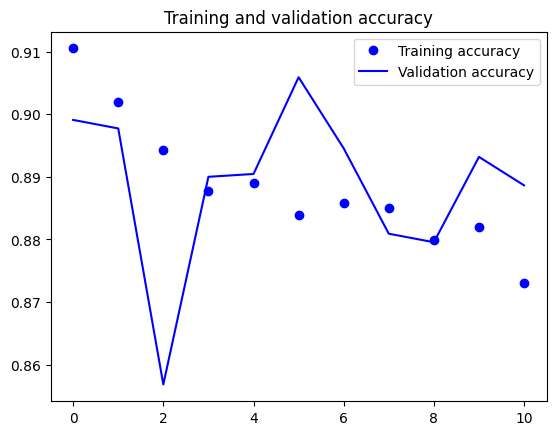

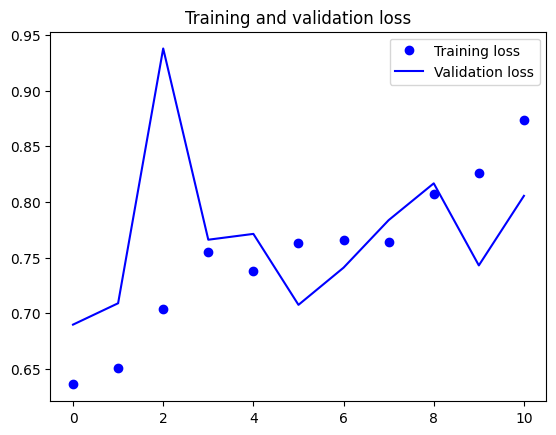

169/169 [==============================] - 1s 5ms/step
Classification report: 
              precision    recall  f1-score   support

           0     0.8208    0.9467    0.8793       600
           1     0.9721    0.9283    0.9497       600
           2     0.8832    0.8950    0.8891       600
           3     0.8889    0.6240    0.7333       500
           4     0.9503    0.9180    0.9339       500
           5     0.7875    0.9450    0.8591       400
           6     0.9258    0.7240    0.8126       500
           7     0.9171    0.9767    0.9459       600
           8     0.7794    0.8620    0.8186       500
           9     0.9365    0.9833    0.9593       600

    accuracy                         0.8852      5400
   macro avg     0.8862    0.8803    0.8781      5400
weighted avg     0.8898    0.8852    0.8827      5400



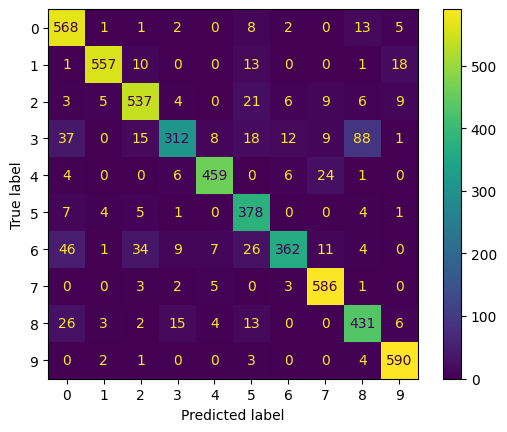

169/169 [==============================] - 1s 5ms/step


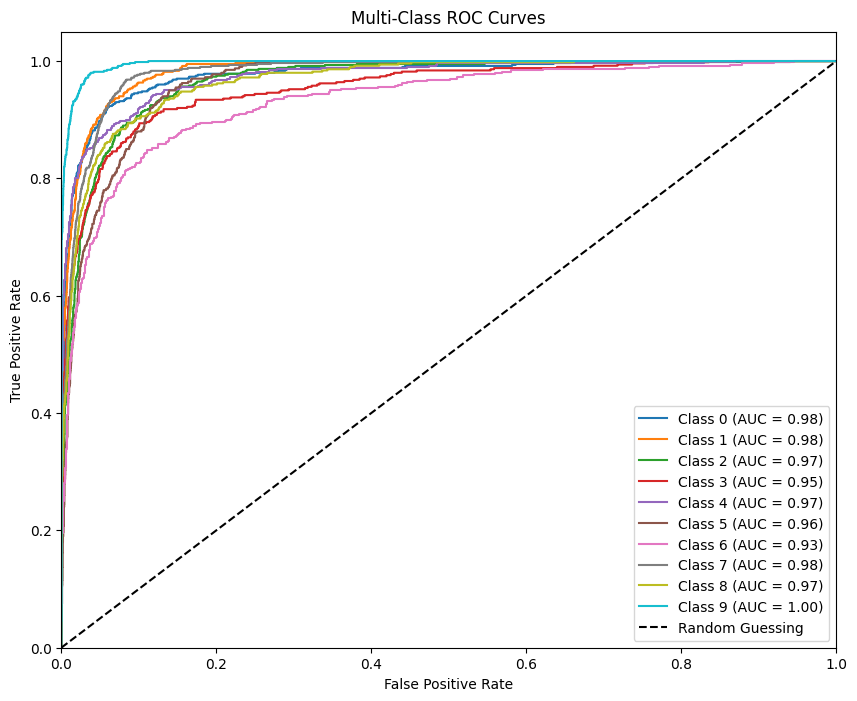

In [ ]:
callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=5,
    ),
    keras.callbacks.ModelCheckpoint(
        #'/content/drive/Shareddrives/Giaquinta_Pasqualetti/Models/vgg16_finetuned.h5',
        '/content/vgg16_finetuned.h5',
        monitor='val_loss',
        mode='min',
        save_best_only=True,
    )
]

train, val, test = load_datasets(BATCH_SIZE = 64)
res = model.fit(train, epochs=15, validation_data=val, callbacks = callbacks_list)
train_performance(res)
show_res(model, test)
plot_multiclass_roc(model, test)

Surely an unstable and unreliable model, fine tuning is not a good idea